## Image classification with Convolutional Neural Networks

Image classification is one of the applications that first showed the potential of deep learning.

Convolutional Neural Networks (CNN) have been found to be especially suitable for this task, and many advancements in deep learning (batch normalization, residual connections, ...) were first proposed in this domain.

## Pet classification

In this exercise, we will address a simple binary classification problem in which we want to distinguish between images of cats and dogs.

We will use the [Oxford Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which includes 7349 images of different breeds of cats and dogs.

## Setup and Data

We will use a preprocessed version of the dataset to speed up the exercise. All images have been resized to $160 \times 160$ pixels. The training set includes 6349 images (2047 cats, 4302 dogs) and 1000 test images (324 cats, 676 dogs). Files have been organized in folders as follows:
- `/train`
  + `train/cat`
  + `train/dog`
- `/test`
  + `test/cat`
  + `test/dog`

We will use the `torchvision.dataset.ImageFolder` class which is perfect for dealing with datasets of that structure.

In [47]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/Colab Notebooks/Pet-classification/pet-classification.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/pet-classification")

print("Extraction complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.


Let's create two `ImageFolder` (EXPECT THE DATA OF SAME TYPE AND ORGANIZATION AS OURS) datasets (train and test) with the corresponding data loaders.

In [49]:
import torchvision
import torch
import matplotlib.pyplot as plt
import google.colab

In [50]:
# torch.manual_seed(42)
# the MEAN and STD estimated using only the train set

MEAN_RGB = [0.4849, 0.4495, 0.3966]
STDDEV_RGB = [0.2631, 0.2584, 0.26252] # WITH 'NATURAL' IMAGE I DON'T EXPECT LARGE STD

tr = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), # FLIP THE IMAGE WITH A CERTAIN PROBABILITY, ONLY IF DOESN'T CHANGE THE MEANING OF THE IMAGE
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(MEAN_RGB, STDDEV_RGB)
    ]) # USUALLY I ALSO AUGMENT THE DATA (ADD NOISE) TO IMPROVE GENERALIZATION

train_set = torchvision.datasets.ImageFolder("/content/pet-classification/pet-classification/train", transform=tr)
item = train_set[10]
# print(item[0].shape) # RGB X pixel X pixel
# plt.imshow(item[0].permute(1,2,0)) # permute to change shape as expected by plt
# plt.show()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True) #drop last batch cause last batch might be of one image(bad for SGD)
                                                              # shuffle is necessary otherwise SGD will be bad (otherwise first all cats then dogs)

tr = torchvision.transforms.Compose([
    # v.transforms.RandomHorizontalFlip(), # don't flip in test, i don't need to generalize, i've already did, also i want the set to be equal every time
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(MEAN_RGB, STDDEV_RGB)
])

test_set = torchvision.datasets.ImageFolder(
    "/content/pet-classification/pet-classification/test", transform=tr)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True, num_workers=2,
    drop_last=False)



torch.Size([64])


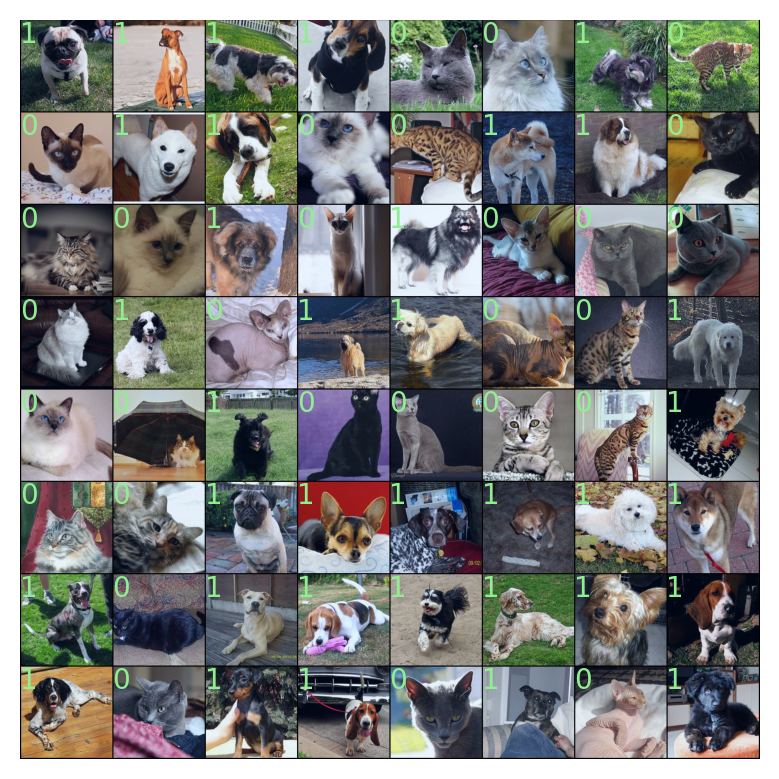

In [51]:
# torch.manual_seed(42)
def show_batch(images, labels, predictions):
  plt.rcParams["figure.dpi"] = 200
  grid = torchvision.utils.make_grid(images, normalize=True)
  plt.imshow(grid.permute(1,2,0))
  for i in range(len(labels)):
    row = i//8
    col=i%8
    x = col *162
    y = 40 + row * 162
    if labels is not None:
      color = "lightgreen" if labels[i] == predictions[i] else 'red'
      txt = train_set.classes[labels[i]]
      txt = 1 if txt == 'dog' else 0
      plt.text(x,y,txt,color=color)
  plt.axis("off")
  plt.show()

images, labels = next(iter(train_loader))
print(labels.shape)
show_batch(images,labels, labels)

In [52]:
type(images)

torch.Tensor

## Convolutional Networks for image classification

Convolutional Neural Networks are a very effective model for image classification. The network is divided in two parts: a feature extractor and a classifier.

The feature extractor is just a sequence of *convolutional blocks* including two convolutions, normalization layers, and ReLUs. The second convolution in each block is strided, to reduce the spatial dimension of the resulting feature map.

The classifier computes the average feature vector and applies a linear layer to compute the score, and a sigmoid to compute the probability estimate. Normally, you would need one output score for each class. For binary classification one value is enough.

In [53]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.feature = torch.nn.Sequential(  # at start 160x160 image
            self.make_block(3, 16),
            self.make_block(16, 32),
            self.make_block(32, 64),
            self.make_block(64, 128),
            self.make_block(128, 256)  # at the end 5x5 image
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1), # 1 size of the output(1x1 image)   # INSTEAD OF FLATTEN
            torch.nn.Flatten(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()  # since binary class
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

    def make_block(self, in_channels, out_channels):  # usally double channels but reduce image size
        block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),  # padding to keep the same size image, 3x3 convolution, skip 2 pixels
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1), # stride = skip 2 pixels
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block


net = CNN()
x = torch.rand(1, 3, 160, 160)
y = net(x)  # y.shape == [1,1] so 1 value for 1 image
print(x.shape, y.shape)

params = sum(p.numel() for p in net.parameters())
print(params, "parameters") # usually 10 milion parameters

torch.Size([1, 3, 160, 160]) torch.Size([1, 1])
1181009 parameters


## Training loop

A loss function suitable for binary classification is the Binary Cross Entropy, defined as the average over a batch of the following expression:

$L_{\text{BCE}} = -y \log p - (1 - y) \log (1 - p),$

where $p \in (0, 1)$ is the probability estimate computed by the CNN, and $y \in \{0, 1\}$ is the actual class label.

We will use the Adam optimization method to minimize the BCE loss. This method is similar to Stochastic Gradient Descent but less sensitive to the choice of the hyperparameters.

In [54]:
# torch.manual(42)
EPOCHS = 10
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), LR) # net.paramters() i want to optimze every parameter, Adam is less sensitive to LR choice
loss_fun = torch.nn.BCELoss().to(DEVICE)  # binary cross entropy

net.train()
steps = 0
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()  # zero the gradient
        probs = net(images)
        loss = loss_fun(probs.squeeze(1), labels.float())# squeeze because shape(1,1) but shape label is (1)
        loss.backward()
        optimizer.step()
        steps += 1
        if steps % 50 == 0:
            predictions = (probs > 0.5).long()  # tensor of TRUE and FALSE, convert it to long (int)
            accuracy = 100 * (predictions.squeeze(1) == labels).float().mean()
            print(f"{steps} [{epoch}]  Loss: {loss.item():.4f}  Accuracy: {accuracy:.1f}%")
    data = {
        "classifier": net.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(data, zip_file_path + "classifier.pt")
# loss flactuate cause "lucky" batches and function is NOT convex

Device: cuda
50 [0]  Loss: 0.5416  Accuracy: 76.6%
100 [1]  Loss: 0.6407  Accuracy: 62.5%
150 [1]  Loss: 0.5026  Accuracy: 82.8%
200 [2]  Loss: 0.5455  Accuracy: 75.0%
250 [2]  Loss: 0.5753  Accuracy: 71.9%
300 [3]  Loss: 0.5206  Accuracy: 75.0%
350 [3]  Loss: 0.4725  Accuracy: 75.0%
400 [4]  Loss: 0.3927  Accuracy: 78.1%
450 [4]  Loss: 0.5382  Accuracy: 71.9%
500 [5]  Loss: 0.4271  Accuracy: 79.7%
550 [5]  Loss: 0.4681  Accuracy: 78.1%
600 [6]  Loss: 0.3827  Accuracy: 87.5%
650 [6]  Loss: 0.5652  Accuracy: 71.9%
700 [7]  Loss: 0.4157  Accuracy: 84.4%
750 [7]  Loss: 0.5202  Accuracy: 79.7%
800 [8]  Loss: 0.3265  Accuracy: 92.2%
850 [8]  Loss: 0.3131  Accuracy: 85.9%
900 [9]  Loss: 0.4675  Accuracy: 78.1%
950 [9]  Loss: 0.2846  Accuracy: 87.5%


## Evaluation

For this problem, accuracy (i.e., fraction of correct predictions) is a reasonable performance measure.

In [55]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
data = torch.load(zip_file_path + "classifier.pt", map_location=DEVICE) # use device i'm usng now and not the one i was usign when saving data
net.to(DEVICE)
net.load_state_dict(data["classifier"])
# optimizer.load_state_dict(data["optimizer"])

Device: cuda


<All keys matched successfully>

In [56]:
net.eval()
mis_images=[] # short for misclassificated_images
def get_prediction(loader, record_misclassification):
  first=True
  second=False
  correct, tot, prediction_as_dogs = 0, 0, 0
  global mis_images
  for images, labels in loader:
      images = images.to(DEVICE) # list of tensor with shape (pos_in_batch, channel, pixel, pixel)
      labels = labels.to(DEVICE)
      with torch.no_grad():
          probs = net(images)
      predictions = (probs > 0.5).long() # tensor of TRUE and FALSE, convert it to long (int)
      correct += (predictions.squeeze(1) == labels).long().sum().item()
      temp = predictions.squeeze(1) == labels
      if record_misclassification: # save only misclassified images
        position = [i for i, prediction in enumerate(temp) if prediction.item()==False]
        mis_images.extend([images[i].cpu() for i in position])
      else:
        labels = predictions.squeeze(1)
      prediction_as_dogs += (predictions.squeeze(1) == True).long().sum().item()
      tot += labels.shape[0]
      if first:
        if second:
          first = False
          second = False
          show_batch(images.cpu(), labels.cpu(), predictions.squeeze(1).cpu())
        second = True
  prediction_as_dogs = 100 * prediction_as_dogs / tot
  accuracy = 100 * correct / tot
  print(f"prediction_as_dog: {prediction_as_dogs:.1f}%")
  print(f"accuracy: {accuracy:.1f}%")

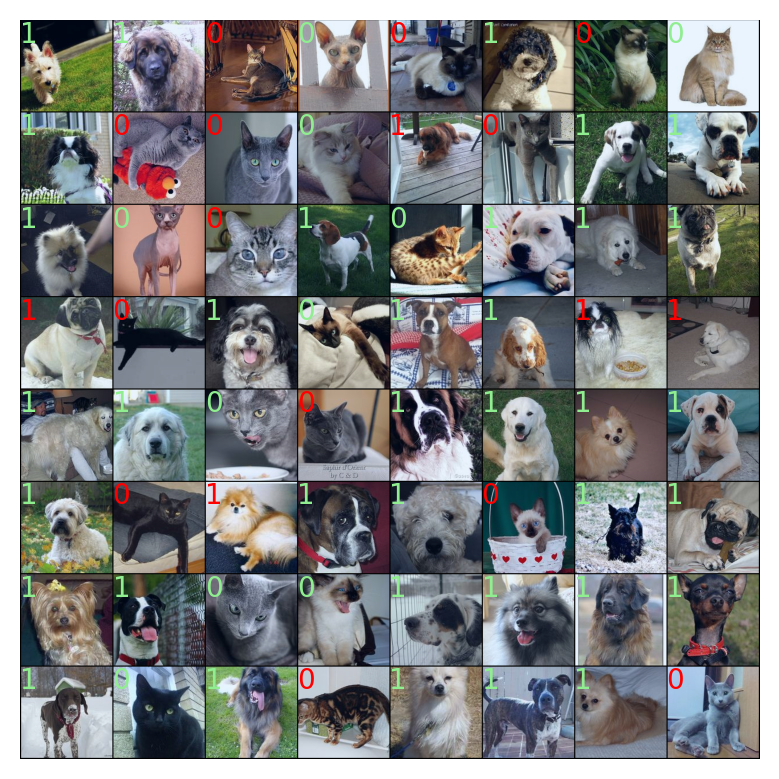

prediction_as_dog: 65.7%
accuracy: 82.5%


In [57]:
# torch.manual_seed(42)
get_prediction(test_loader, record_misclassification=True)

## Extensions

The model presented here are by no means optimal. Try to identify the best combination of parameters, also by adjusting the number of features, blocks etc.

Other possible investigations:
* Identify how frequently each class is misclassified as the other (i.e., build a confusion matrix.
* Find the worst predictions made by the model: can you guess why these mistakes were made?
* Try data augmentation, such as random crop, described [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Try introducing [dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d) to improve generalization.


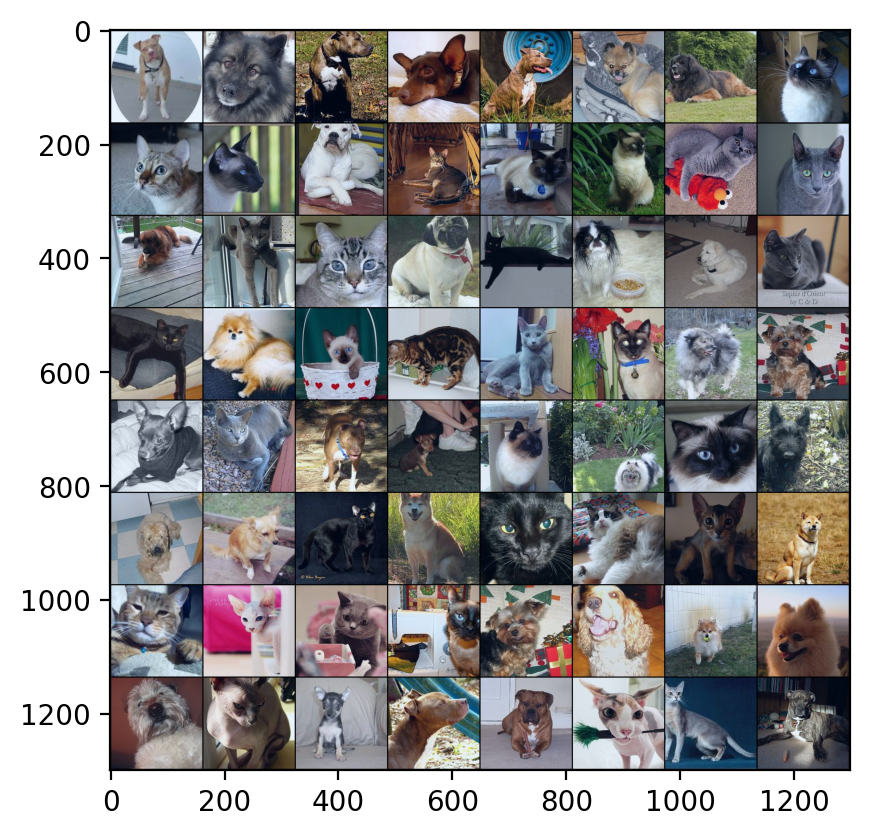

In [58]:
# show only misclassified images
plt.rcParams["figure.dpi"] = 200
grid = torchvision.utils.make_grid(mis_images[:64], normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.show()

1. Building a Confusion Matrix


Accuracy: 82.5%


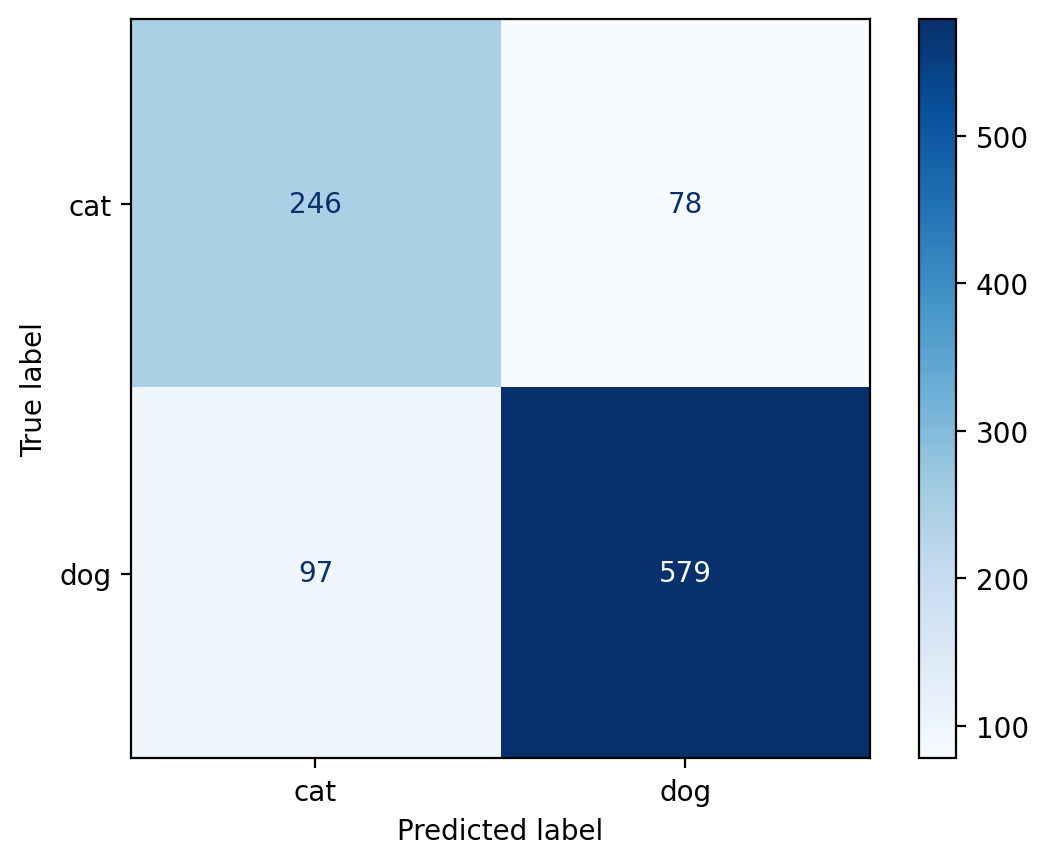

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to get predictions and record misclassifications
def get_predictions_and_misclassifications(loader, record_misclassification):
    mis_images = []
    mis_labels = []
    mis_predictions = []
    correct, tot = 0, 0
    all_labels = []
    all_predictions = []

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            probs = net(images)
        predictions = (probs > 0.5).long()
        correct += (predictions.squeeze(1) == labels).long().sum().item()

        if record_misclassification:
            temp = predictions.squeeze(1) == labels
            position = [i for i, prediction in enumerate(temp) if not prediction.item()]
            mis_images.extend([images[i].cpu() for i in position])
            mis_labels.extend([labels[i].cpu().item() for i in position])
            mis_predictions.extend([predictions[i].cpu().item() for i in position])

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        tot += labels.shape[0]

    accuracy = 100 * correct / tot
    print(f"Accuracy: {accuracy:.1f}%")

    return all_labels, all_predictions, mis_images, mis_labels, mis_predictions

# Get predictions and misclassifications from the test set
all_labels, all_predictions, mis_images, mis_labels, mis_predictions = get_predictions_and_misclassifications(test_loader, record_misclassification=True)

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_set.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


2. Identifying the Worst Predictions


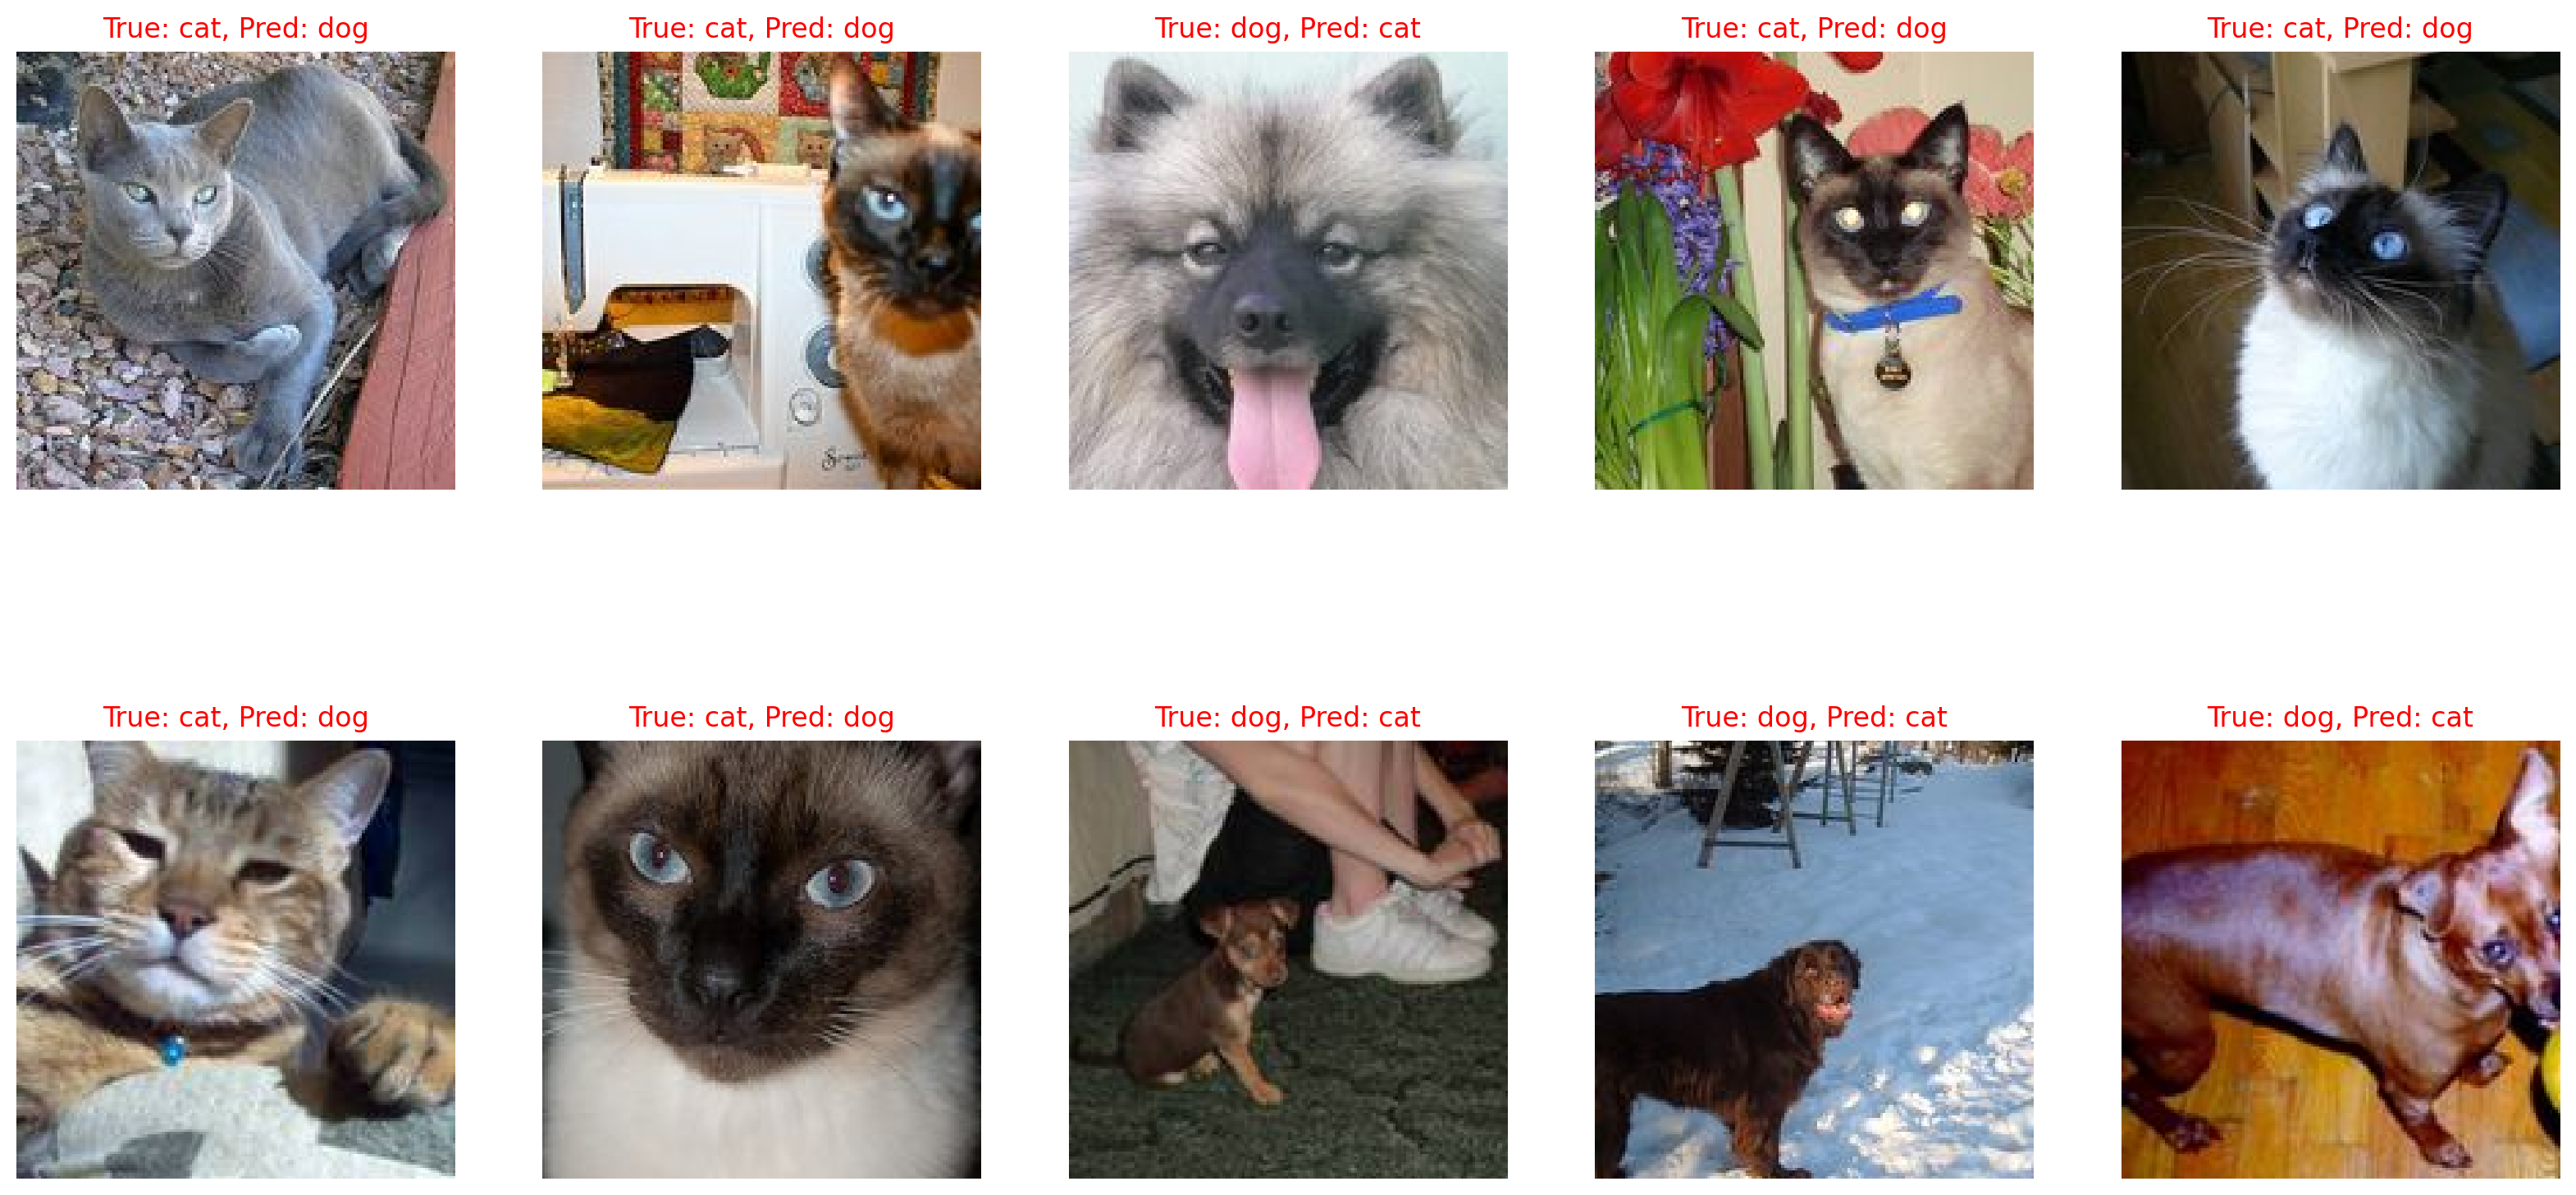

In [60]:
import numpy as np

# Function to unnormalize images
def unnormalize_image(img, mean, std):
    img = img.clone()  # Clone the tensor to avoid modifying the original image
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img

# Function to show misclassified images
def show_misclassified_images(mis_images, mis_labels, mis_predictions, classes, mean, std, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = unnormalize_image(mis_images[i], mean, std).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Ensure values are in the valid range [0, 1]
        plt.imshow(img)
        true_label = classes[mis_labels[i]]
        pred_label = classes[mis_predictions[i]]
        plt.title(f'True: {true_label}, Pred: {pred_label}', color='red')
        plt.axis('off')
    plt.show()

# Example usage:
show_misclassified_images(mis_images, mis_labels, mis_predictions, train_set.classes, MEAN_RGB, STDDEV_RGB)


3. Data Augmentation

In [61]:
# Data Augmentation with Random Crop
tr_augmented = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(160),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(MEAN_RGB, STDDEV_RGB)
])

train_set_augmented = torchvision.datasets.ImageFolder("/content/pet-classification/pet-classification/train", transform=tr_augmented)
train_loader_augmented = torch.utils.data.DataLoader(train_set_augmented, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

# Train the model with augmented data
net = CNN()
net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), LR)
loss_fun = torch.nn.BCELoss().to(DEVICE)

net.train()
steps = 0
for epoch in range(EPOCHS):
    for images, labels in train_loader_augmented:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        probs = net(images)
        loss = loss_fun(probs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        steps += 1
        if steps % 50 == 0:
            predictions = (probs > 0.5).long()
            accuracy = 100 * (predictions.squeeze(1) == labels).float().mean()
            print(f"{steps} [{epoch}]  Loss: {loss.item():.4f}  Accuracy: {accuracy:.1f}%")

# Save the augmented model
torch.save({
    "classifier": net.state_dict(),
    "optimizer": optimizer.state_dict()
}, zip_file_path + "classifier_augmented.pt")

# Evaluate the augmented model
data = torch.load(zip_file_path + "classifier_augmented.pt", map_location=DEVICE)
net.load_state_dict(data["classifier"])
net.eval()

all_labels, all_predictions, mis_images, mis_labels, mis_predictions = get_predictions_and_misclassifications(test_loader, record_misclassification=True)




50 [0]  Loss: 0.5217  Accuracy: 79.7%
100 [1]  Loss: 0.6482  Accuracy: 60.9%
150 [1]  Loss: 0.6106  Accuracy: 73.4%
200 [2]  Loss: 0.5833  Accuracy: 70.3%
250 [2]  Loss: 0.5643  Accuracy: 68.8%
300 [3]  Loss: 0.6933  Accuracy: 64.1%
350 [3]  Loss: 0.6140  Accuracy: 67.2%
400 [4]  Loss: 0.4812  Accuracy: 84.4%
450 [4]  Loss: 0.5608  Accuracy: 68.8%
500 [5]  Loss: 0.6166  Accuracy: 56.2%
550 [5]  Loss: 0.6374  Accuracy: 68.8%
600 [6]  Loss: 0.5634  Accuracy: 67.2%
650 [6]  Loss: 0.4290  Accuracy: 82.8%
700 [7]  Loss: 0.5580  Accuracy: 70.3%
750 [7]  Loss: 0.5416  Accuracy: 71.9%
800 [8]  Loss: 0.5427  Accuracy: 73.4%
850 [8]  Loss: 0.6069  Accuracy: 75.0%
900 [9]  Loss: 0.6196  Accuracy: 56.2%
950 [9]  Loss: 0.5578  Accuracy: 64.1%
Accuracy: 72.2%


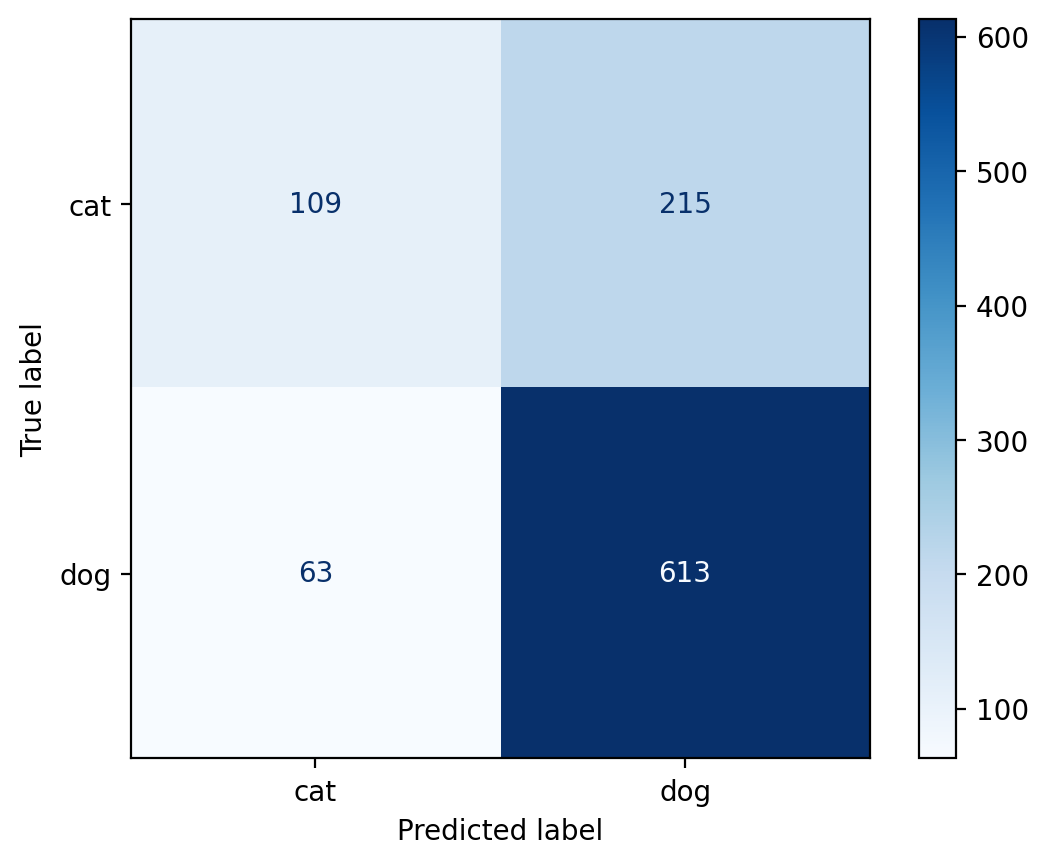

In [62]:
# Confusion matrix for augmented model
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_set.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()



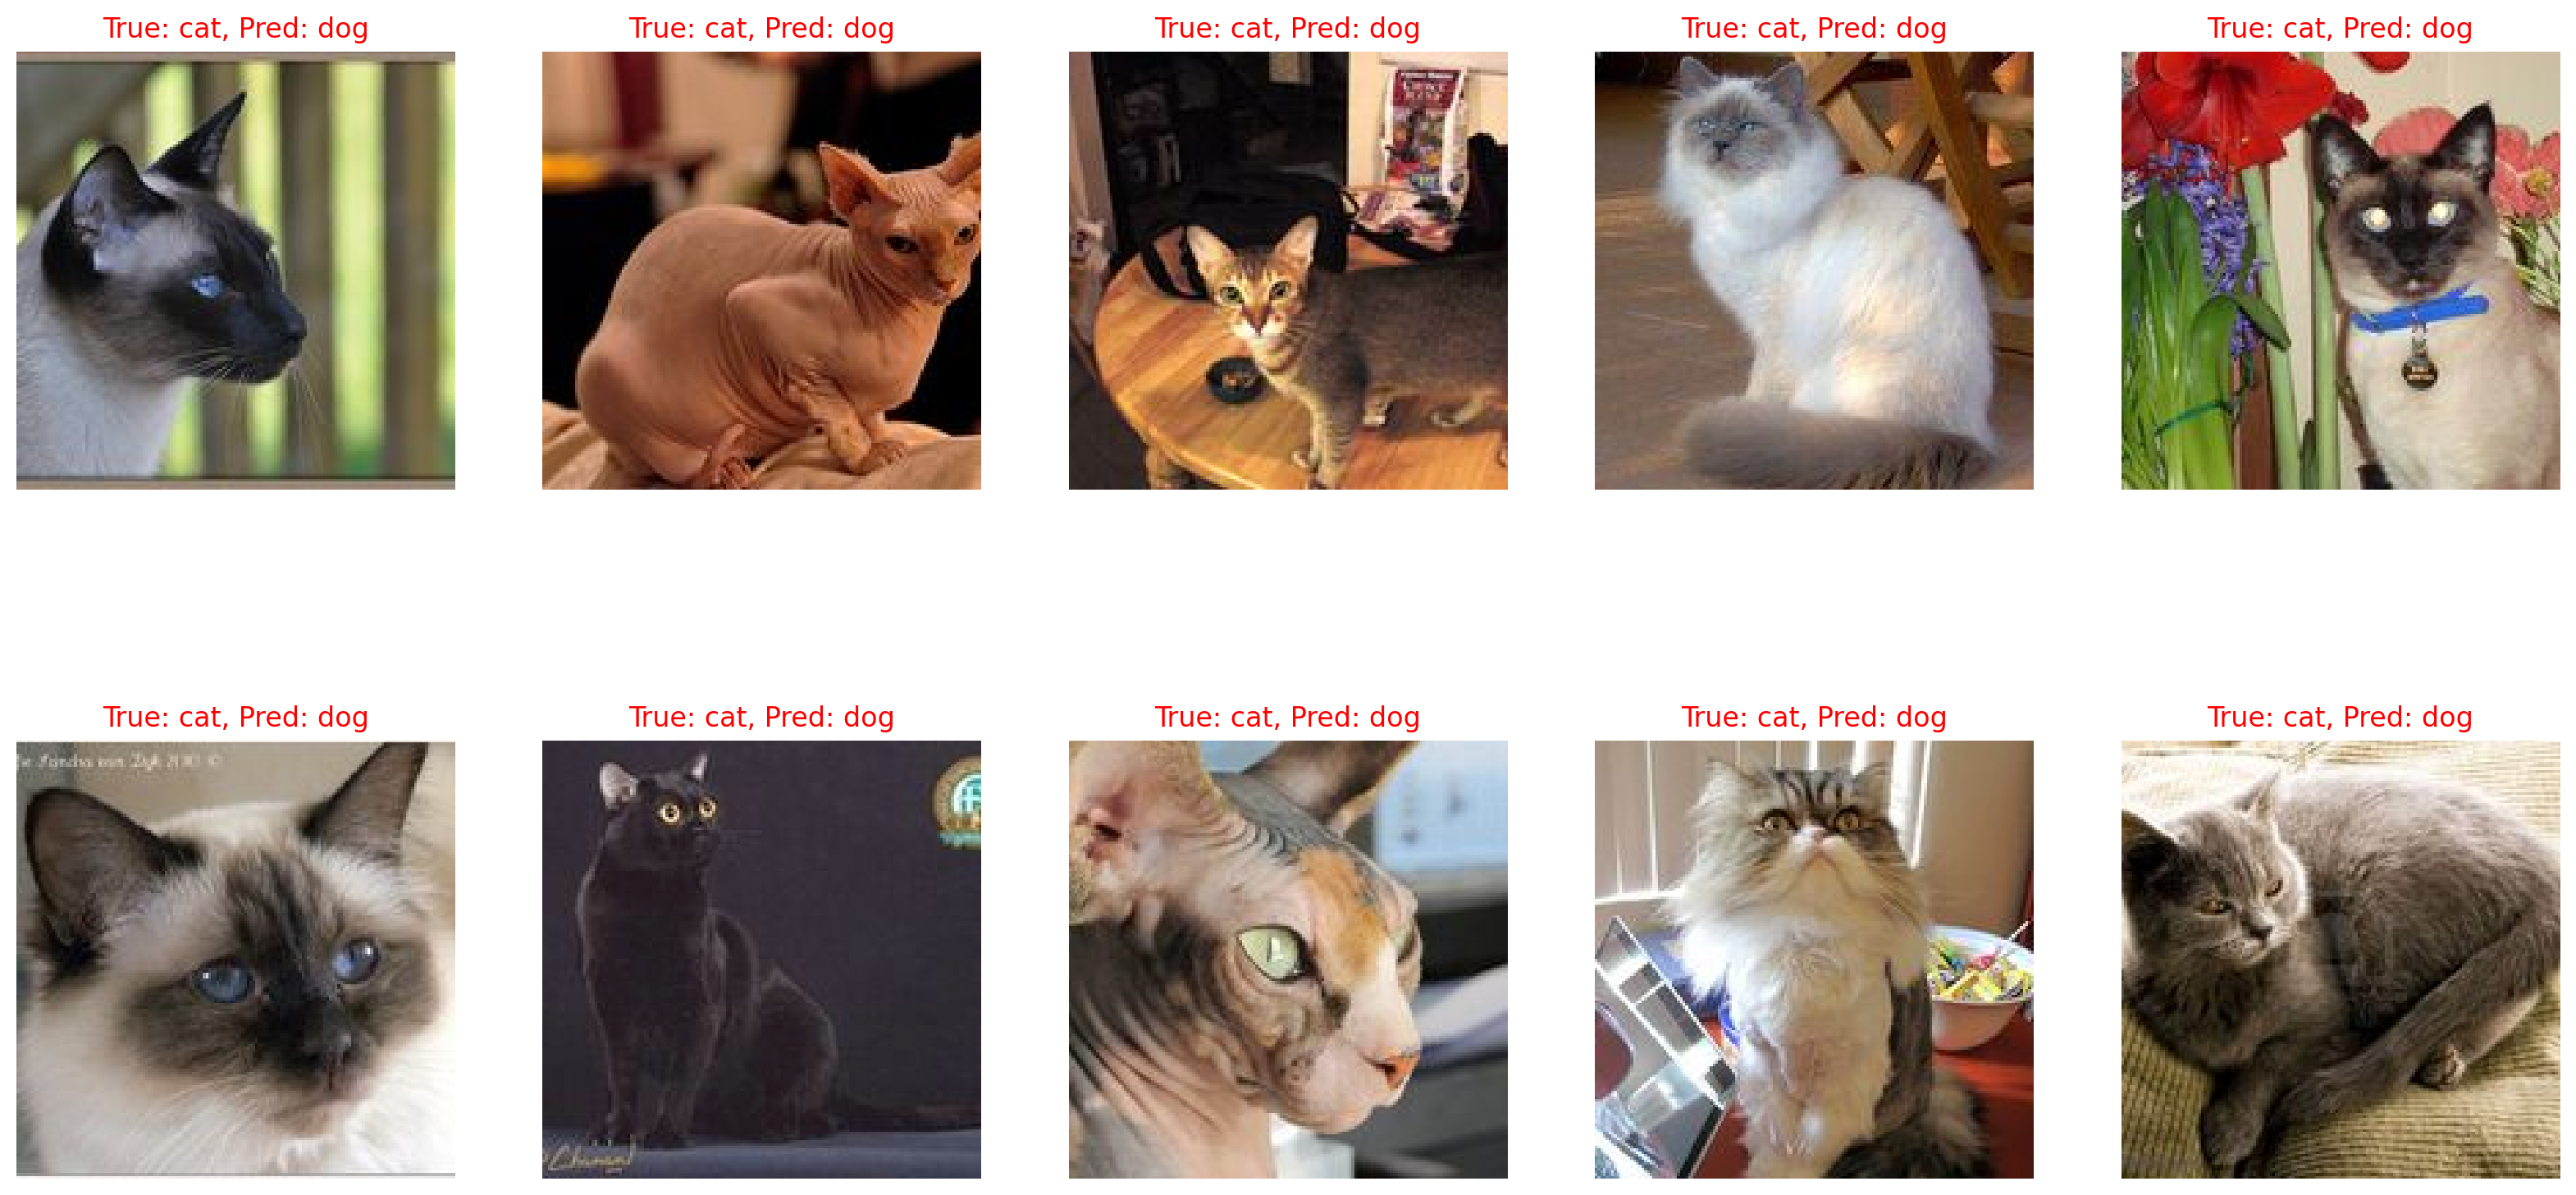

In [63]:
# Show misclassified images
show_misclassified_images(mis_images, mis_labels, mis_predictions, train_set.classes, MEAN_RGB, STDDEV_RGB)

In [65]:
import natsort
from PIL import Image
import os
from torch.utils.data import Dataset
from torchvision.transforms import v2
MEAN_RGB = [0.4849, 0.4495, 0.3966]
STDDEV_RGB = [0.2631, 0.2584, 0.26252]
tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    v2.Resize(size=(160,160)),
    torchvision.transforms.Normalize(MEAN_RGB, STDDEV_RGB)])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
    def __len__(self):
        return len(self.total_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

from torch.utils.data import DataLoader, ConcatDataset
jaguar = CustomDataSet('/content/drive/MyDrive/Colab Notebooks/Pet-classification/archive/cheetah-resize-224/resize-224', transform=tr)
jaguar_loader = torch.utils.data.DataLoader(jaguar , batch_size=64, shuffle=False, num_workers=2, drop_last=True)
fox = CustomDataSet('/content/drive/MyDrive/Colab Notebooks/Pet-classification/archive/fox-resize-224/fox-resize-224', transform=tr)
fox_loader = torch.utils.data.DataLoader(fox , batch_size=64, shuffle=False, num_workers=2, drop_last=True)
lion = CustomDataSet('/content/drive/MyDrive/Colab Notebooks/Pet-classification/archive/lion-resize-224/lion-resize-224', transform=tr)
lion_loader = torch.utils.data.DataLoader(lion , batch_size=64, shuffle=False, num_workers=2, drop_last=True)
dataset = ConcatDataset([jaguar, fox, lion])
new_animals = DataLoader(
    dataset,
    shuffle=False,
    num_workers=0,
    batch_size=64
)

In [66]:
jaguar.__getitem__(1).shape

torch.Size([3, 160, 160])

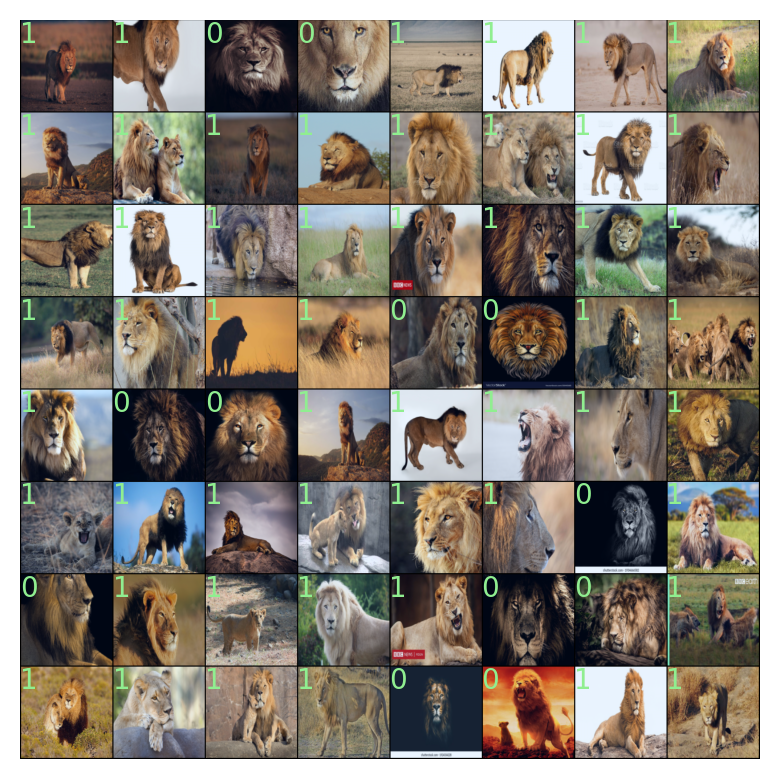

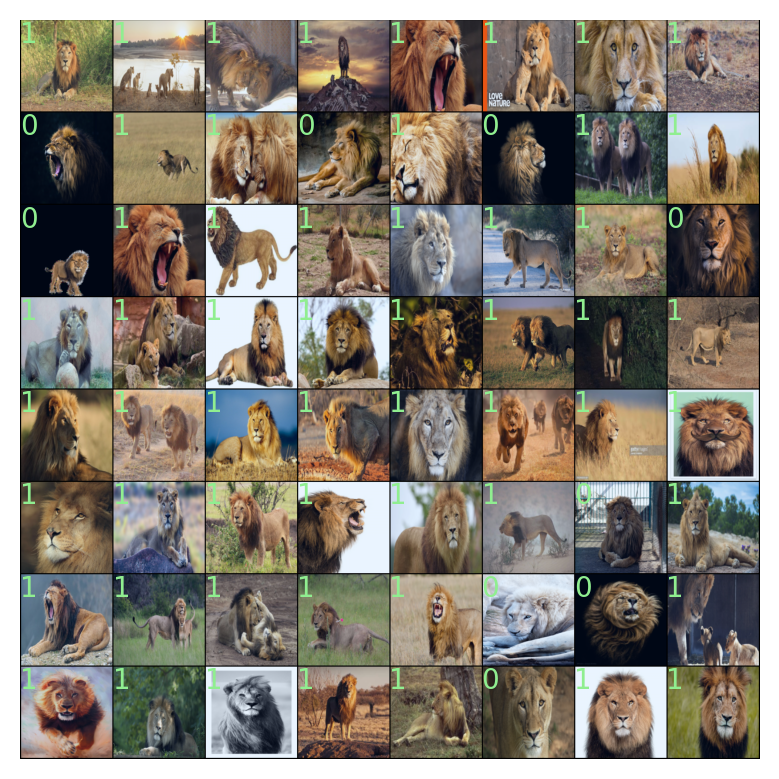

percentage of dogs: 0.859375


In [67]:
net.eval()
# def get_prediction_new_animals(loader):
first=True
second=False
ones = 0
tot = 0
for images in lion_loader:
    images = images.to(DEVICE) # list of tensor with shape (pos_in_batch, channel, pixel, pixel)
    with torch.no_grad():
        probs = net(images)
    predictions = (probs > 0.5).long() # tensor of TRUE and FALSE, convert it to long (int)
    if first:
      if second:
        first = False
        second = False
      show_batch(images.cpu(), predictions.squeeze(1).cpu(), predictions.squeeze(1).cpu())
      second = True
    ones += predictions.sum().item()
    tot += images.shape[0]
print("percentage of dogs:", ones/tot)